<a href="https://colab.research.google.com/github/nemoiitkgp/FWI-Codes-PhD/blob/main/SEG_EAGE_Overthrust_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install deepwave scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 14.9 MB/s eta 0:00:00


Device: cuda
Model shape (nx, nz) = (801, 187)
Velocity range: 2365.1–6000.0 m/s


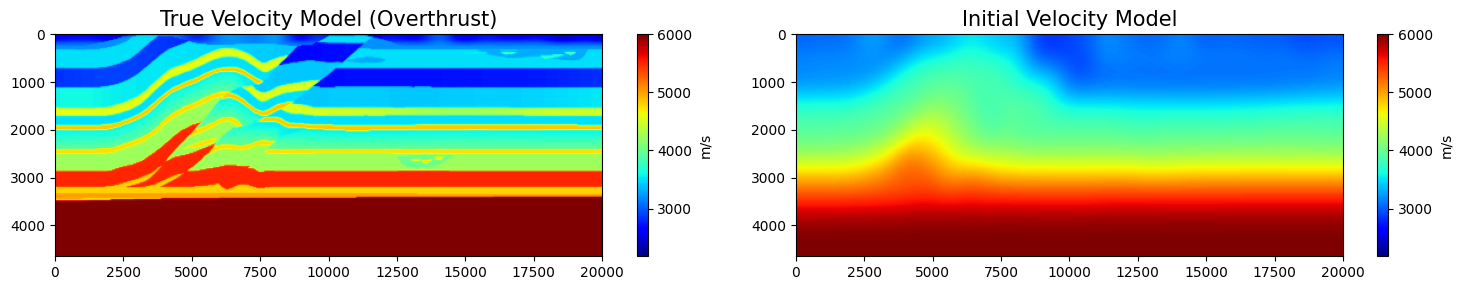

Generating observed data in batches...


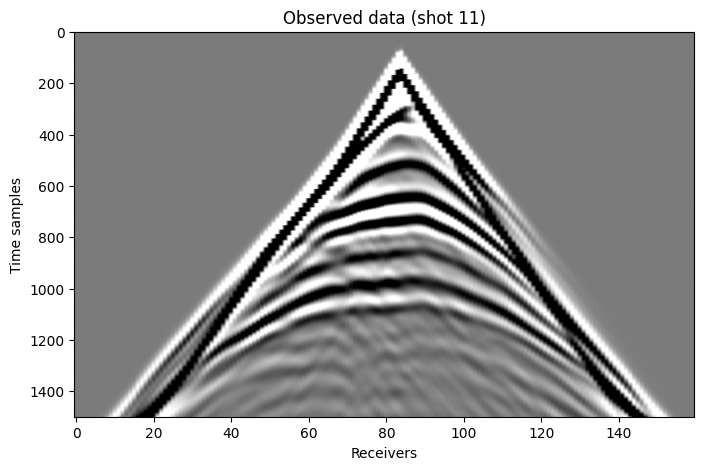

Starting Inversion Loop (Batch size = 2)...
Epoch 300: loss=0.03198, v_min=2178.0, v_max=6000.0


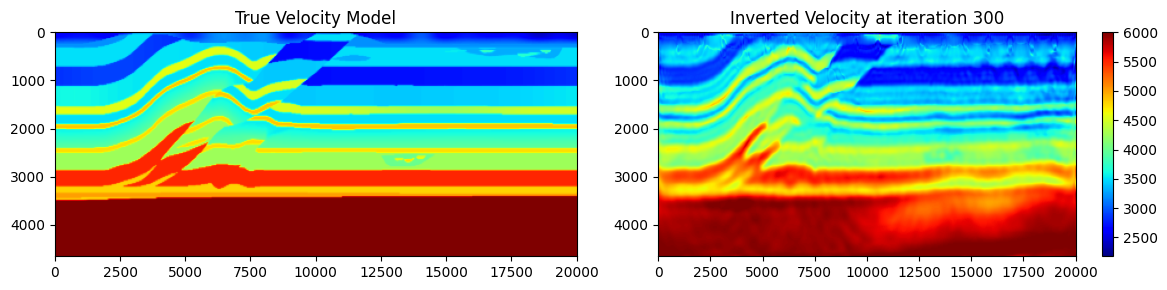

Epoch 600: loss=0.01526, v_min=2239.9, v_max=6000.0


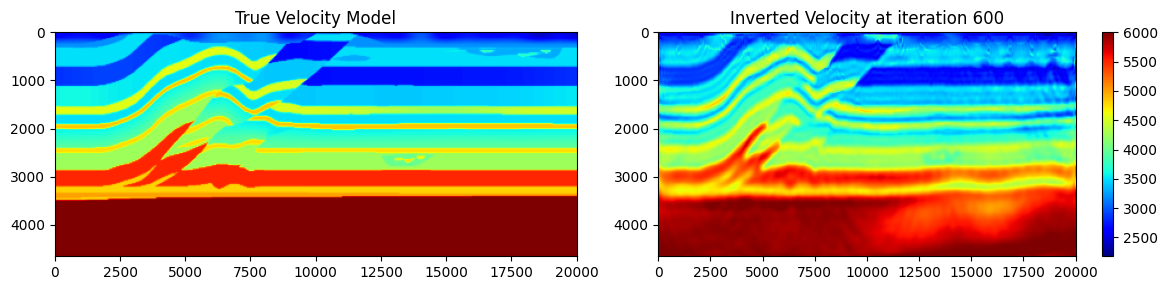

Epoch 900: loss=0.00808, v_min=2253.9, v_max=6000.0


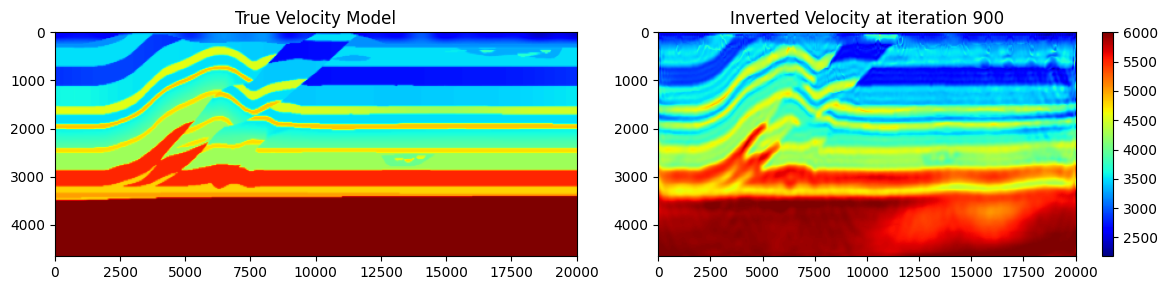

Epoch 1200: loss=0.00539, v_min=2250.4, v_max=6000.0


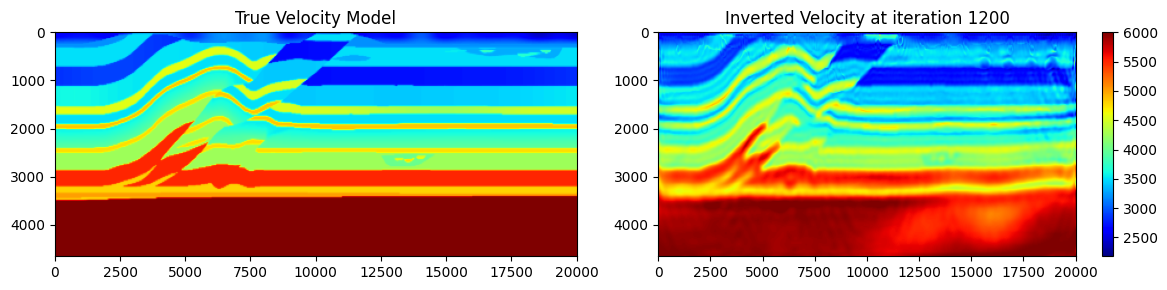

Epoch 1500: loss=0.00440, v_min=2244.0, v_max=6000.0


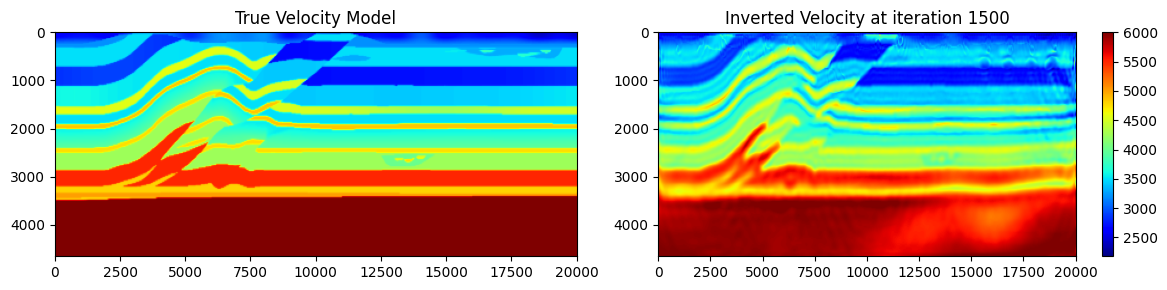

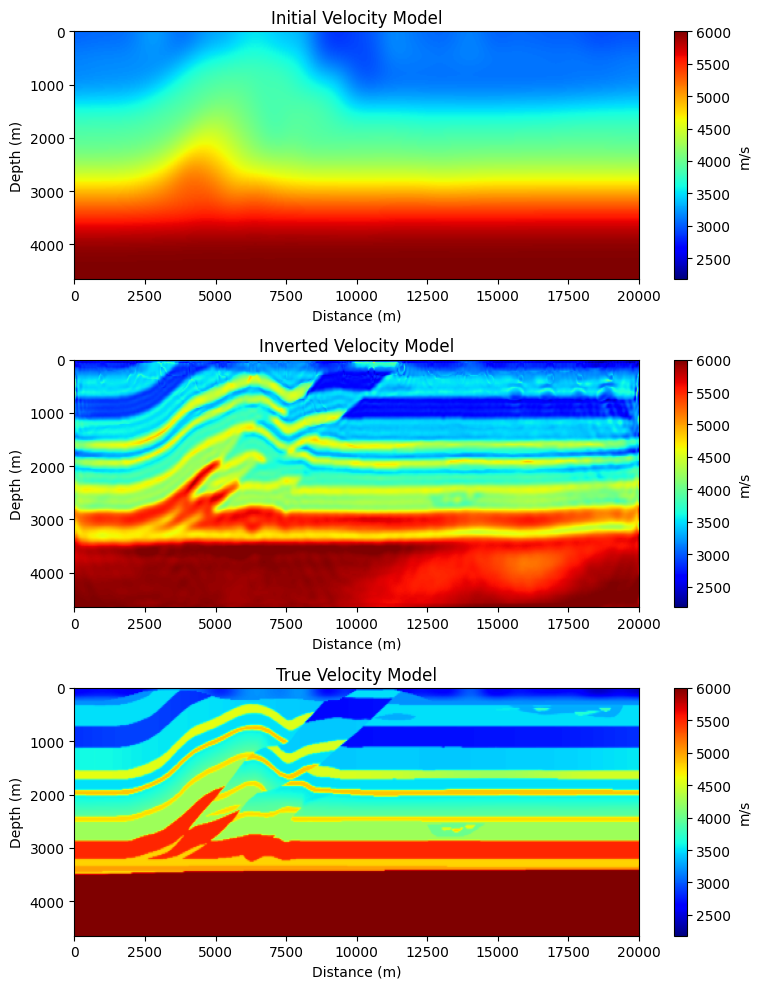

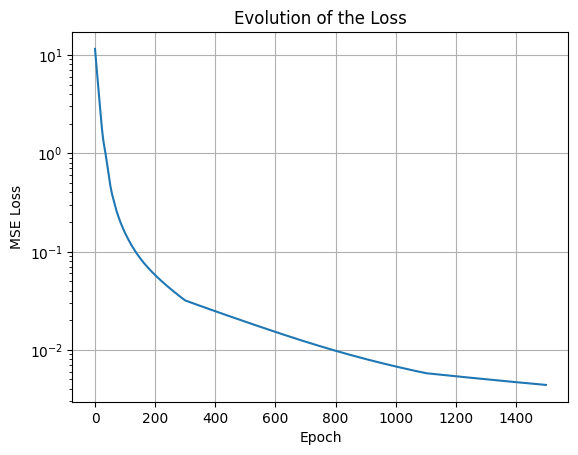

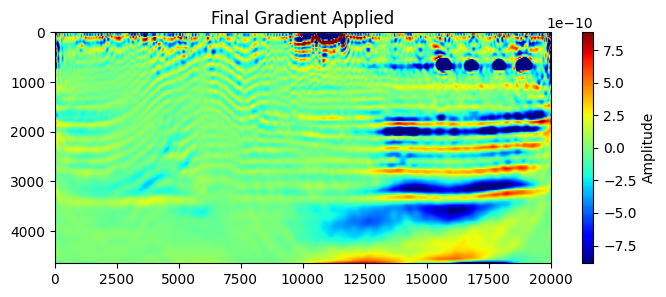

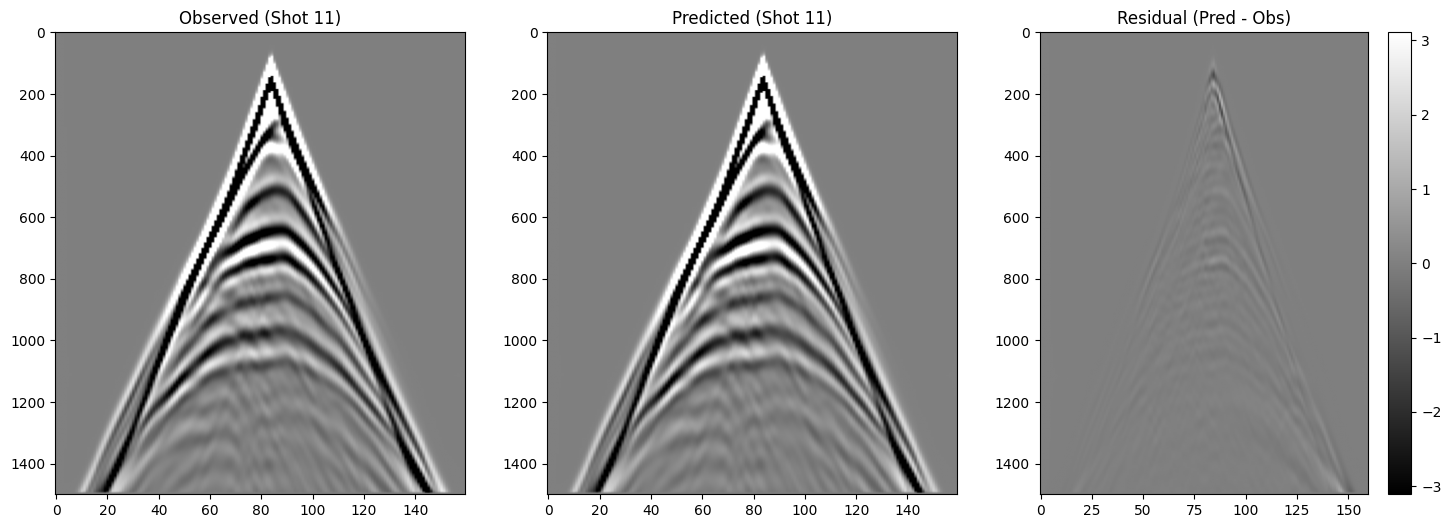

Final Metrics - Shot 11: MSE=5.122e-03, RelL2=2.229e-02


In [2]:
# !pip install deepwave

# LIBRARIES AND SETTINGS
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# Device: GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 1. INPUT: OVERTHRUST VP BINARY FILE
vp_path = 'overthrust2D'
nx, nz = 801, 187

# Load binary (Float32)
v_true = torch.from_file(vp_path, size=nx * nz, dtype=torch.float32).reshape(nx, nz).to(device)

# Grid spacing (25m from your 0.025km script)
dx, dz = 25.0, 25.0
spacing = (dx, dz)
extent = [0, (nx - 1) * dx, (nz - 1) * dz, 0]

# 2. INITIAL VELOCITY MODEL
# Create a smooth starting model
v_init = (torch.tensor(1/gaussian_filter(1/v_true.cpu().numpy(), sigma=15)).to(device))
v1 = v_init.clone()
v1.requires_grad_()

print(f"Model shape (nx, nz) = {tuple(v_true.shape)}")
print(f"Velocity range: {v_true.min().item():.1f}–{v_true.max().item():.1f} m/s")

# PLOT TRUE AND INITIAL VELOCITY MODELS
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
im1 = ax1.imshow(v_true.cpu().T, cmap='jet', aspect='auto', vmin=2178, vmax=6000, extent=extent)
ax1.set_title('True Velocity Model (Overthrust)', fontsize=15)
im2 = ax2.imshow(v_init.cpu().T, cmap='jet', aspect='auto', vmin=2178, vmax=6000, extent=extent)
ax2.set_title('Initial Velocity Model', fontsize=15)
fig1.colorbar(im1, ax=ax1, label='m/s')
fig1.colorbar(im2, ax=ax2, label='m/s')
plt.tight_layout()
plt.show()

# 3. ACQUISITION GEOMETRY
n_shots = 20
n_sources_per_shot = 1
n_receivers_per_shot = 160
freq = 5.0
dt = 0.002               # 2ms for numerical stability
nt = 1500
peak_time = 1.5/freq

source_loc = torch.zeros(n_shots, n_sources_per_shot, 2, dtype=torch.long, device=device)
source_loc[..., 1] = 2 # Source depth
source_loc[:, 0, 0] = torch.linspace(0, nx - 1, n_shots).round()

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 2 # Receiver depth
receiver_loc[:, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).round()

source_amp = (deepwave.wavelets.ricker(freq, nt, dt, peak_time)
              .repeat(n_shots, n_sources_per_shot, 1).to(device))

# 4. FORWARD MODELLING (Generated in small batches to fit in RAM)
print("Generating observed data in batches...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
batch_size = 2 # Small batch size to ensure it fits in 15GB RAM

with torch.no_grad():
    for i in range(0, n_shots, batch_size):
        out = scalar(v_true, spacing, dt,
                     source_amplitudes=source_amp[i:i+batch_size],
                     source_locations=source_loc[i:i+batch_size],
                     receiver_locations=receiver_loc[i:i+batch_size],
                     accuracy=4, pml_freq=freq)
        observed_data[i:i+batch_size] = out[-1]

# PLOT OBSERVED DATA FOR ONE SHOT
shot_idx = n_shots // 2
obs_plot = observed_data[shot_idx].cpu()
amin, amax = torch.quantile(obs_plot, torch.tensor([0.05, 0.95]))
plt.figure(figsize=(8, 5))
plt.imshow(obs_plot.T, cmap='gray', aspect='auto', vmin=amin, vmax=amax)
plt.xlabel('Receivers'); plt.ylabel('Time samples')
plt.title(f'Observed data (shot {shot_idx + 1})')
plt.show()

# 5. INVERSION SETUP
def taper(x, n_taper=10):
    return deepwave.common.cosine_taper_end(x, n_taper)

observed_data_tapered = taper(observed_data)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam([v1], lr=15.0)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimiser, milestones=[300, 1100], gamma=0.5)

# 6. OPTIMIZATION LOOP
n_epochs = 1500
losses = []
gradients = []
vmin_plot, vmax_plot = 2178.0, 6000.0

print("Starting Inversion Loop (Batch size = 2)...")
for epoch in range(n_epochs):
    optimiser.zero_grad()
    epoch_loss = 0

    # Process shots in small batches to keep GPU memory usage low
    for i in range(0, n_shots, batch_size):
        out_pred = scalar(v1, spacing, dt,
                          source_amplitudes=source_amp[i:i+batch_size],
                          source_locations=source_loc[i:i+batch_size],
                          receiver_locations=receiver_loc[i:i+batch_size],
                          accuracy=4, pml_freq=freq)

        pred_batch = out_pred[-1]
        # Calculate loss for this batch
        loss = loss_fn(taper(pred_batch), observed_data_tapered[i:i+batch_size])

        # Scale loss so the gradient is averaged over all shots correctly
        loss = loss / (n_shots / batch_size)
        loss.backward() # Accumulates gradient into v1.grad
        epoch_loss += loss.item()

    # Gradient Post-processing
    with torch.no_grad():
        grad = v1.grad.detach().cpu().numpy()
        grad_smoothed = gaussian_filter(grad, sigma=1.0)
        v1.grad.copy_(torch.tensor(grad_smoothed).to(device))

        # Clip gradient to stabilize inversion
        clip_value = torch.quantile(v1.grad.abs(), 0.98)
        torch.nn.utils.clip_grad_value_([v1], clip_value)

    optimiser.step()
    scheduler.step()

    # Constrain velocity to physical limits
    with torch.no_grad():
        v1.clamp_(min=vmin_plot, max=vmax_plot)

    losses.append(epoch_loss)

    # Visualise progress
    if (epoch + 1) % 300 == 0:
        gradients.append(v1.grad.clone().detach().cpu())
        print(f"Epoch {epoch+1}: loss={epoch_loss:.5f}, v_min={v1.min().item():.1f}, v_max={v1.max().item():.1f}")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
        ax1.imshow(v_true.cpu().T, vmin=vmin_plot, vmax=vmax_plot, cmap='jet', aspect='auto', extent=extent)
        ax1.set_title('True Velocity Model')
        im2 = ax2.imshow(v1.detach().cpu().T, vmin=vmin_plot, vmax=vmax_plot, cmap='jet', aspect='auto', extent=extent)
        ax2.set_title(f'Inverted Velocity at iteration {epoch+1}')
        plt.colorbar(im2, ax=ax2)
        plt.tight_layout()
        plt.show()

# 7. FINAL PREDICTED DATA
with torch.no_grad():
    predicted_data = torch.zeros_like(observed_data)
    for i in range(0, n_shots, batch_size):
        out = scalar(v1, spacing, dt,
                     source_amplitudes=source_amp[i:i+batch_size],
                     source_locations=source_loc[i:i+batch_size],
                     receiver_locations=receiver_loc[i:i+batch_size],
                     accuracy=4, pml_freq=freq)
        predicted_data[i:i+batch_size] = out[-1]

# 8. PLOTTING FINAL RESULTS
fig1, ax1 = plt.subplots(3, figsize=(8, 10))
imgs = [v_init.cpu(), v1.detach().cpu(), v_true.cpu()]
titles = ["Initial Velocity Model", "Inverted Velocity Model", "True Velocity Model"]

for i in range(3):
    im = ax1[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin_plot, vmax=vmax_plot, extent=extent)
    ax1[i].set_title(titles[i])
    ax1[i].set_xlabel("Distance (m)"); ax1[i].set_ylabel("Depth (m)")
    fig1.colorbar(im, ax=ax1[i], label='m/s')
plt.tight_layout()
plt.show()

# LOSS VALUES
plt.figure()
plt.plot(losses); plt.yscale('log')
plt.title("Evolution of the Loss"); plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.grid(); plt.show()

# GRADIENT
plt.figure(figsize=(8, 3))
plt.imshow(gradients[-1].T, cmap='jet', aspect='auto', extent=extent)
plt.title("Final Gradient Applied")
plt.colorbar(label='Amplitude')
plt.show()

# OBSERVED, PREDICTED, AND RESIDUAL
shot = n_shots // 2
obs = observed_data_tapered[shot].detach().cpu()
pred = taper(predicted_data)[shot].detach().cpu()
res = pred - obs
amp = torch.quantile(obs.abs(), 0.95).item()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(obs.T, aspect="auto", cmap="gray", vmin=-amp, vmax=amp)
axes[0].set_title(f"Observed (Shot {shot+1})")
axes[1].imshow(pred.T, aspect="auto", cmap="gray", vmin=-amp, vmax=amp)
axes[1].set_title(f"Predicted (Shot {shot+1})")
im2 = axes[2].imshow(res.T, aspect="auto", cmap="gray", vmin=-amp, vmax=amp)
axes[2].set_title("Residual (Pred - Obs)")
plt.colorbar(im2, ax=axes[2])
plt.show()

# METRICS
mse = torch.mean(res**2).item()
rel = (torch.norm(res) / torch.norm(obs)).item()
print(f"Final Metrics - Shot {shot+1}: MSE={mse:.3e}, RelL2={rel:.3e}")